## LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) designed to address the problem of capturing long-term dependencies in sequential data.
### LSTM Gates
1. Forget Gate: Controls what information from the previous cell state should be discarded or kept based on the current input.

2. Input Gate: Determines which new information from the current input should be stored in the cell state.

3. Cell State: Represents the memory of the LSTM, preserving information over long sequences by selectively adding or removing information.

4. Output Gate: Filters the information from the current cell state to produce the output based on the current input and the LSTM's internal state.


#### LSTM (Long Short-Term Memory) is a type of RNN (Recurrent Neural Network) designed to address the issue of capturing long-term dependencies in sequential data.

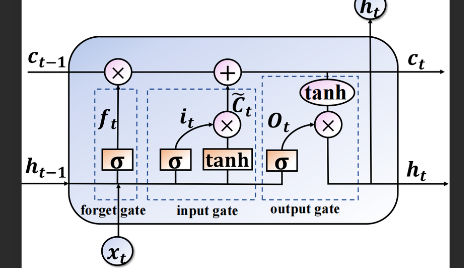
- LSTMs have a memory cell that can retain information over long periods.
- They incorporate gating mechanisms (input, forget, and output gates) to control the flow of information into and out of the memory cell.
- Input gate: Determines which new information to incorporate into the memory cell.
- Forget gate: Decides which information to discard from the memory cell.
- Output gate: Regulates the information output from the memory cell to the next time step.
- LSTMs are trained using backpropagation through time (BPTT), allowing them to learn to capture long-range dependencies in the data.
- LSTMs are widely used in tasks such as language modeling, speech recognition, and time series prediction due to their ability to effectively capture long-range dependencies.
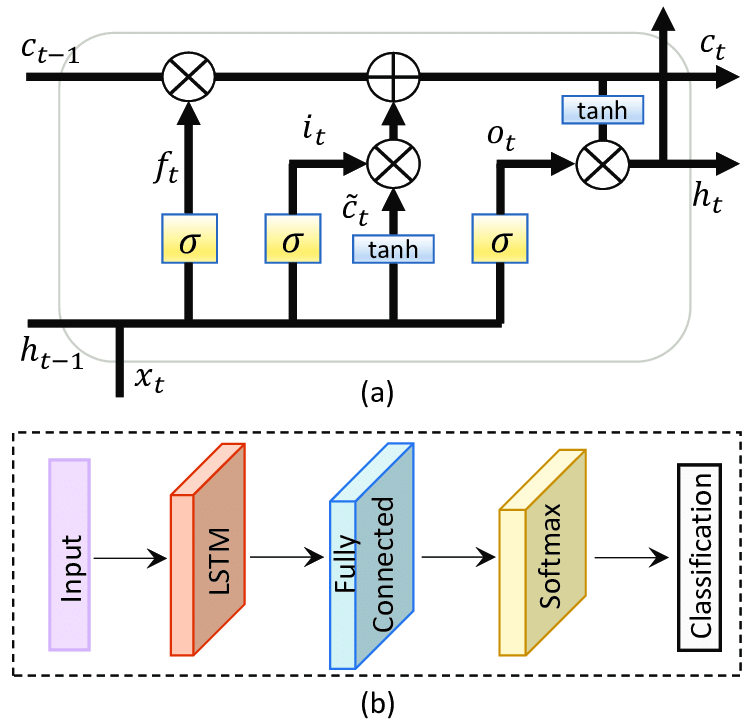

### A simple example of an LSTM network using Python and the Keras library

- Example Data: We create a simple sequential dataset (data) where each row has two features. LSTM expects input in the form [samples, time steps, features], so we reshape data accordingly.

- LSTM Model: We define a sequential Keras model (Sequential) and add an LSTM layer (LSTM) with 50 units (you can adjust this number as needed), using ReLU activation function. The input_shape specifies that each sample has 1 time step and 2 features.

In [1]:
# Importing necessary libraries
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Example data
# Let's create some simple sequential data for demonstration
data = np.array([[0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6]])

# Reshape data for LSTM input [samples, time steps, features]
data = data.reshape((data.shape[0], 1, data.shape[1]))

# Creating LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, 2)))
model.add(Dense(1))

# Compiling the model
model.compile(optimizer='adam', loss='mse')

# Fitting the model
model.fit(data, data, epochs=300, verbose=0)

# Predicting on new data (similar to the input data for simplicity)
predictions = model.predict(data, verbose=0)

# Printing predictions
print(predictions)

C:\Users\Suyashi144893\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[[0.27867734]
 [0.30992123]
 [0.3407215 ]
 [0.37219268]
 [0.4043356 ]]


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Generate some random data for demonstration
# Input sequence: [0.1, 0.2, 0.3, 0.4, 0.5]
# Output sequence: [0.6, 0.7, 0.8, 0.9, 1.0]


In [2]:
# Define input sequence
X = np.array([[[0.1], [0.2], [0.3], [0.4], [0.5]]])

# Define output sequence
y = np.array([[0.6, 0.7, 0.8, 0.9, 1.0]])

In [5]:
# Define and build the LSTM model
model = Sequential([
    LSTM(50, input_shape=(5, 1)),  # 50 units in LSTM layer
    Dense(5)  # Output layer
])



# Compile the model
model.compile(optimizer='adam', loss='mse')


In [6]:

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_2 (Dense)             (None, 5)                 255       
                                                                 
Total params: 10,655
Trainable params: 10,655
Non-trainable params: 0
_________________________________________________________________


In [7]:


# Train the model
model.fit(X, y, epochs=100, verbose=1)

# Make predictions
predictions = model.predict(X)

# Print predictions
print("Predictions:")
print(predictions)


Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.6636
Epoch 2/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6515
Epoch 3/100
1/1 [==============================] - 0s 17ms/step - loss: 0.6395
Epoch 4/100
1/1 [==============================] - 0s 19ms/step - loss: 0.6276
Epoch 5/100
1/1 [==============================] - 0s 21ms/step - loss: 0.6158
Epoch 6/100
1/1 [==============================] - 0s 18ms/step - loss: 0.6040
Epoch 7/100
1/1 [==============================] - 0s 21ms/step - loss: 0.5922
Epoch 8/100
1/1 [==============================] - 0s 16ms/step - loss: 0.5803
Epoch 9/100
1/1 [==============================] - 0s 13ms/step - loss: 0.5684
Epoch 10/100
1/1 [==============================] - 0s 23ms/step - loss: 0.5565
Epoch 11/100
1/1 [==============================] - 0s 25ms/step - loss: 0.5444
Epoch 12/100
1/1 [==============================] - 0s 26ms/step - loss: 0.5321
Epoch 13/100
1/1 [==============================] -

## Quick Practice Generate an input sequence consisting of Even numbers and predict the next odd number in the sequence


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Function to generate an input sequence of even numbers
def generate_input_sequence(start, length):
    sequence = [2 * i for i in range(start, start + length)]
    return np.array(sequence)

# Generate input sequence with 100 rows
input_sequence = generate_input_sequence(start=1, length=100)

# Output sequence (next even number in the sequence)
output_sequence = input_sequence[1:]


In [8]:
input_sequence 

array([  2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,  26,
        28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,  52,
        54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,
        80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102, 104,
       106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130,
       132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156,
       158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182,
       184, 186, 188, 190, 192, 194, 196, 198, 200])

In [9]:
output_sequence = input_sequence[1:]
output_sequence

array([  4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,  26,  28,
        30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,  52,  54,
        56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,  80,
        82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102, 104, 106,
       108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132,
       134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158,
       160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184,
       186, 188, 190, 192, 194, 196, 198, 200])

In [10]:


# Preprocess the data
def create_dataset(input_sequence, output_sequence, time_steps):
    X, y = [], []
    for i in range(len(input_sequence) - time_steps):
        X.append(input_sequence[i:i+time_steps])
        y.append(output_sequence[i])
    return np.array(X), np.array(y)

time_steps = 3  # Number of time steps (length of input sequence for each training example)
X, y = create_dataset(input_sequence, output_sequence, time_steps)

# Define the RNN model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(time_steps, 1)),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Reshape input for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train the model
model.fit(X, y, epochs=100, verbose=0)

# Test data for final prediction
test_data = np.array([input_sequence[-3:]])  # Taking the last three elements of the input sequence

# Generate the output sequence
def generate_prediction(model, test_data):
    x_input = test_data.reshape((1, time_steps, 1))
    y_pred = model.predict(x_input, verbose=0)
    return int(y_pred[0][0])

# Final prediction
next_even_number = generate_prediction(model, test_data)

print("Final Prediction (Next Even Number):", next_even_number)


Final Prediction (Next Even Number): 198
